# Predicting Bitcoin Price Using Metcalfe's Law
Metcalfe's Law states that the value of a network is proportional to the square of the number of users on the network. Below is facebook, as an example (stolen from [Wikipedia](https://en.wikipedia.org/wiki/Metcalfe%27s_law#Validation_with_actual_data)):

\begin{equation*}
V = 5.70\times10^{-9}\times n^{2}
\end{equation*}

[Fundstrat](http://www.businessinsider.com/bitcoin-price-movement-explained-by-one-equation-fundstrat-tom-lee-metcalf-law-network-effect-2017-10#ampshare=http://www.businessinsider.com/bitcoin-price-movement-explained-by-one-equation-fundstrat-tom-lee-metcalf-law-network-effect-2017-10) had the idea to try and apply this formula to the price of bitcoin. Unique bitcoin addresses are used as a proxy for number of network users.

Fundstrat also added to this formula the number of transactions per user. Per the article, they arrived at their formula as such:
> FundStrat found a formula by regressing the price of bitcoin against both unique addresses squared and transaction volume per user. This model explained 94% of the variation in the cryptocurrency price since 2013.

Something like:
\begin{equation*}
BTC = x\times n^{2} \times \frac tn
\end{equation*}

Where X is a constant, n is number of addresses, and t is transactions

In this notebook, I try and replicate these results. Ultimately, I was able to reproduce the results by *not* normalizing the number of transactions (using the raw transaction volume instead) as such:

\begin{equation*}
BTC = x\times n^{2} \times t
\end{equation*}

Using the above formula I achieve the same 94% accuracy.

## Getting the data

First, import the required modules:

In [1]:
import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import linear_model
from sklearn.metrics import r2_score

sb.set(font_scale=2.0)
%matplotlib inline

We will use the excellent [blockchain.info](https://blockchain.info/) to acquire the necessary data. Blockchain.info has charts for nearly every aspect of bitcoin. All charts are accessible via an API that returns JSON objects

The below function fetches the data, parses out the relevant portion and returns it as a pandas ```Dataframe```.

In [2]:
def get_data(address):
    r = requests.get(address)
    data = r.json()
    data = pd.DataFrame(data['values'])
    return data

In [3]:
# fetch all data
addresses = get_data('https://api.blockchain.info/charts/n-unique-addresses?timespan=all&format=json')
price = get_data('https://api.blockchain.info/charts/market-price?timespan=all&format=json')
volume = get_data('https://api.blockchain.info/charts/estimated-transaction-volume-usd?timespan=all&format=json')

Once we have our data, we'll rename the columns, convert timestamps to ```datetime``` objects, and reindex by date

In [4]:
# rename columns
addresses.columns = ['date', 'addresses']
volume.columns = ['date', 'volume']
price.columns = ['date', 'price']

In [5]:
# convert unix-stye timestamps into datetime objects
addresses.date = addresses.date.apply(datetime.fromtimestamp)
volume.date = volume.date.apply(datetime.fromtimestamp)
price.date = price.date.apply(datetime.fromtimestamp)

In [6]:
# reindex the dataframe by date
addresses.set_index(keys='date', inplace=True)
volume.set_index(keys='date', inplace=True)
price.set_index(keys='date', inplace=True)

We'll join the dataframes so we only have one dataframe we need to worry about for the rest of the notebook

In [7]:
data = price.join([addresses, volume], how='outer')

It looks like these API endpoints will sometimes return data for different days (ie one returns odd-numbered dates and the other even-numbered dates.) Let's interpolate the data to make sure there are no gaps

In [8]:
data = data.interpolate()
data.tail()

,price,addresses,volume
date,,,
2017-11-04 20:00:00,7377.01,555458,1.309727e+09
2017-11-06 19:00:00,7092.12,714349,1.826009e+09
2017-11-08 19:00:00,7158.03,727945,2.267000e+09
2017-11-10 19:00:00,6362.85,455431,1.344146e+09
2017-11-12 19:00:00,6550.22,694828,2.115296e+09


Looks good. We only care about the last ~3 years, so let's cut that out of the dataframe

In [9]:
# get the last ~3 years
data = data.tail(1150)

Great! Let's take a look at what we have. Since all three values are on such different scales, we'll look at them separately

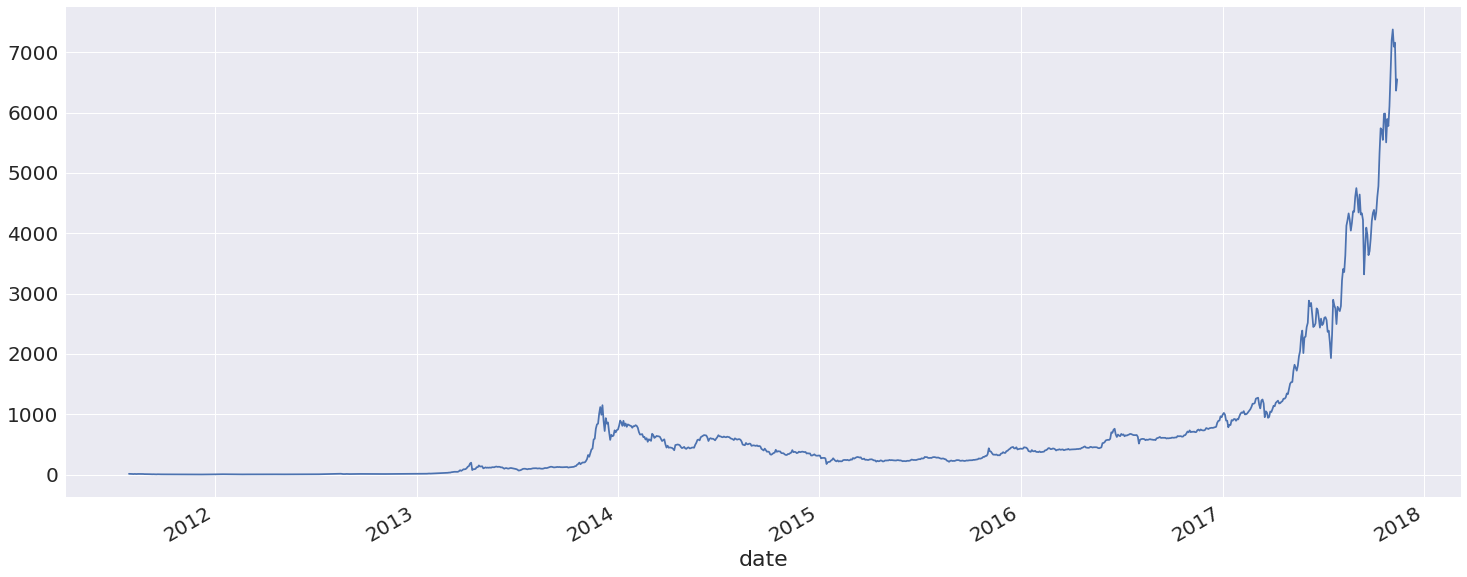

In [10]:
data.price.plot(figsize=(25,10))

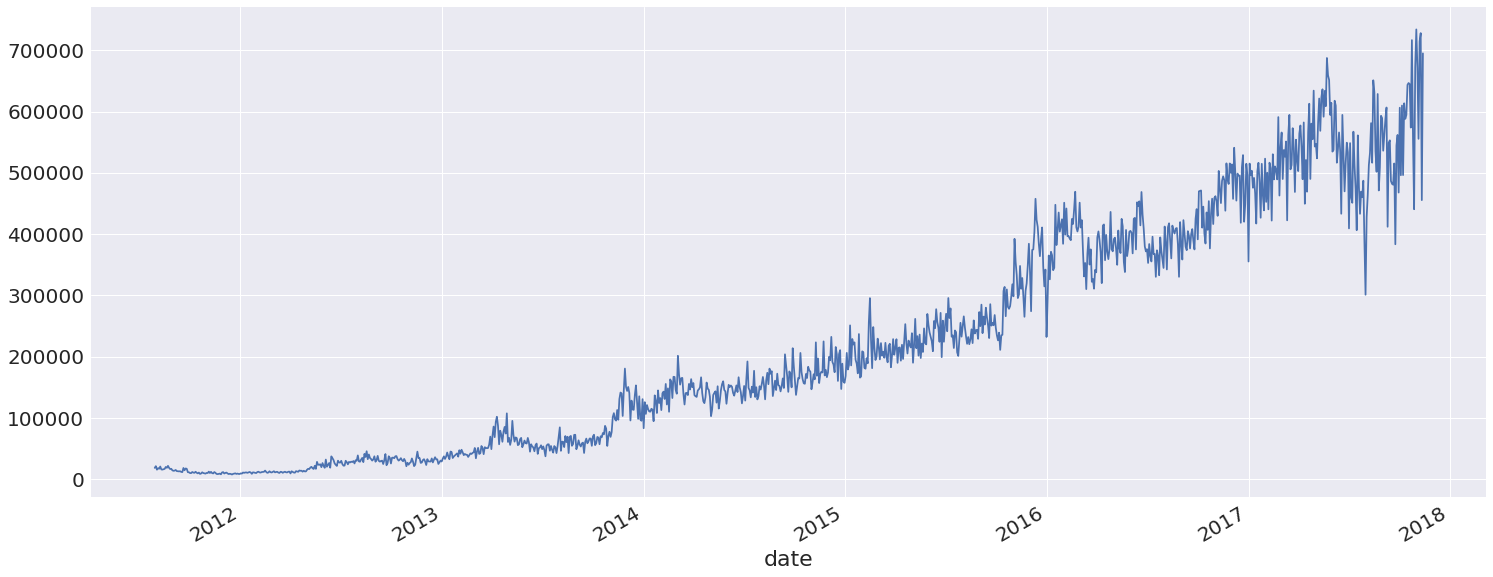

In [11]:
data.addresses.plot(figsize=(25,10))

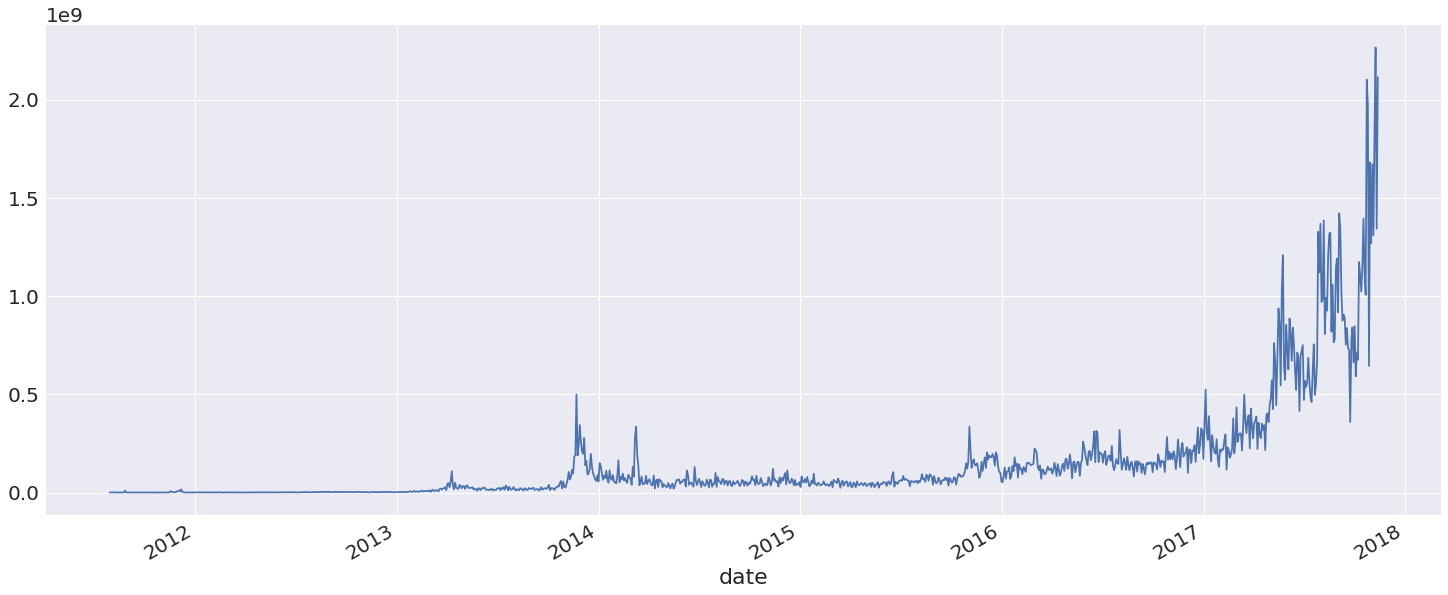

In [12]:
data.volume.plot(figsize=(25,10))

Hard to tell if there's any relationship here. What's clear is that the data is pretty noisy, so let's smooth it out by applying an exponentially-weighted moving average

In [13]:
# smoothing
data = pd.ewma(data, span=7)

/home/asadik/miniconda3/envs/fundstrat/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(span=7,min_periods=0,adjust=True,ignore_na=False).mean()
  from ipykernel import kernelapp as app


## Fitting the model

Ok, now we have the data. Let us try and do something with it.

Here we are going to use [Scikit Learn](http://scikit-learn.org/stable/)'s [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model to fit our data. 

First we create the classifier:

In [14]:
clf = linear_model.LinearRegression(n_jobs=2)

Next we pull our inputs out of the ```data``` dataframe into a new ```train``` dataframe

In [15]:
train = data[['addresses', 'volume']]

Per Metcalfe's law, we will square the number of "users:"

In [16]:
train.addresses = train.addresses.pow(2)

/home/asadik/miniconda3/envs/fundstrat/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Next we grab our target output ```price``` and put it in its own dataframe

In [17]:
y = data['price']

Finally, we fit the model:

In [18]:
clf.fit(train, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=False)

Fitting the model should happen pretty quickly (less than a second on a modern machine.) 

## Analyzing Results
Now we can take a look at the results. We use the classifiers ```predict``` function to run through our test set and produce expected outputs (prices). We then join this with the actual prices, rename the columns, and plot the results for the past year.

In [19]:
pred = pd.DataFrame(clf.predict(train), index=data.index)

In [20]:
compare = pred.join(data['price'])

In [21]:
compare.columns = ['predicted', 'actual']

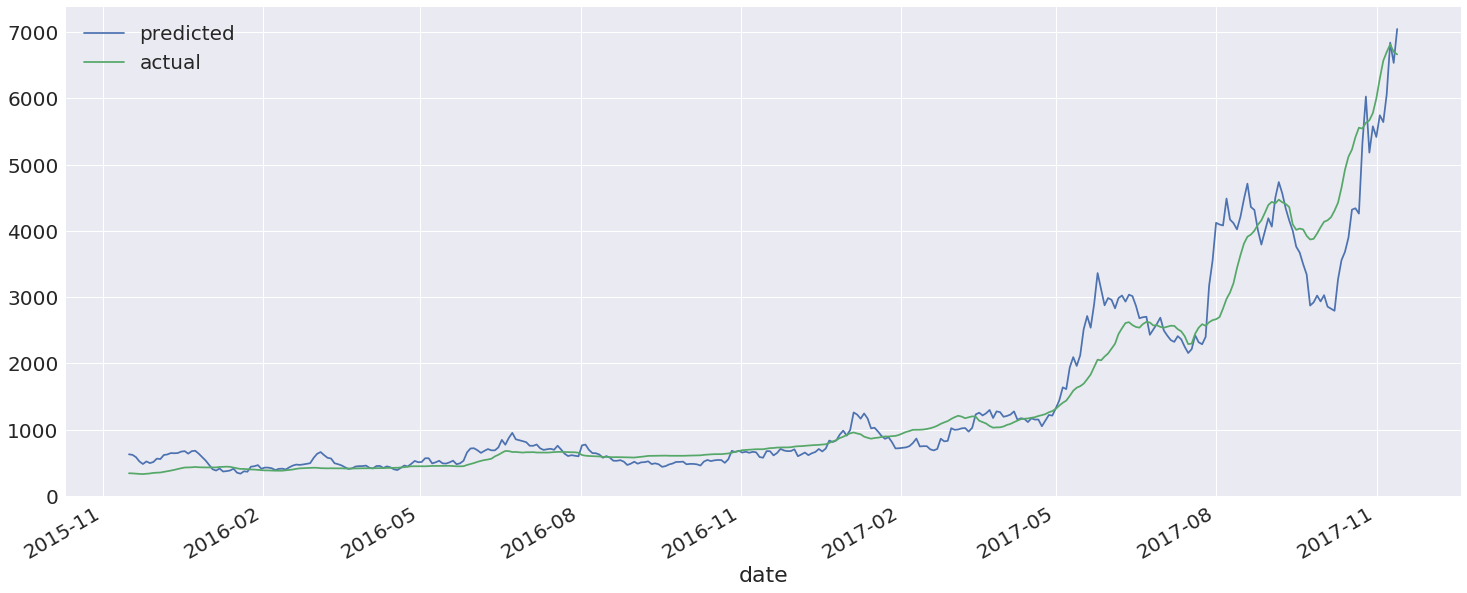

In [22]:
compare.tail(365).plot(figsize=(25,10))

It looks like we have a pretty good fit here. Let's take a closer look at the last ten days

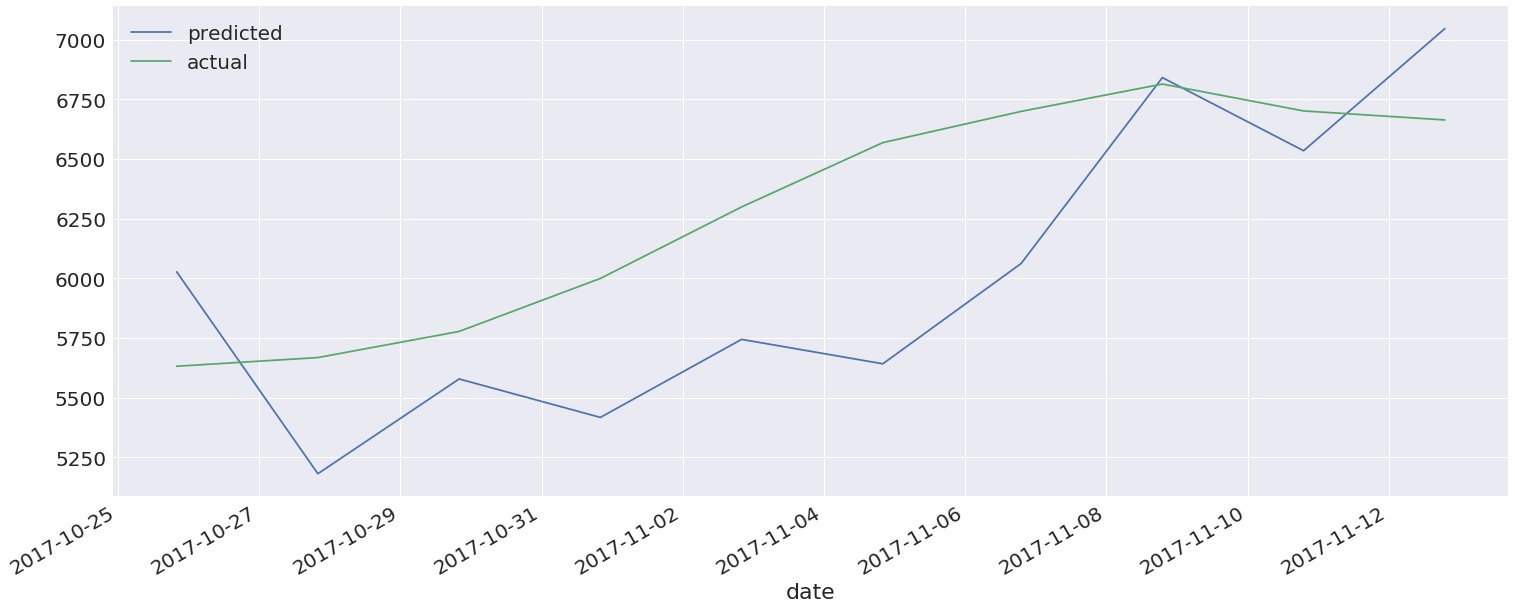

In [23]:
compare.tail(10).plot(figsize=(25,10))

At the time of this writing Bitcoin is (somewhat shockingly) *undervalued.*

We can take a look at the r-score to see that we achieved the same results as described in the article:

In [24]:
r2_score(y, pred)

0.94264680416237079

The data is current to 11/13 and shows Bitcoin at a predicted price of ~7000 USD and an actual price of ~6700 USD. Given that Bitcoin is currently trading at ~7200 USD on GDAX as of this writing (11/15), it seems that this model has some value.

This is probably not very useful for investment purposes, though, as the data generally lags too far behind what's actually happening. Still, it's interesting to see that Bitcoin userbase and trading volume appear to be closely correlated with price.